In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from helper_functions import *
import tensorflow as tf
from IPython.display import Image

# Load data

In [2]:
train = pickle.load(open('quora_questions_train_features_v2.pickle', 'rb'))
test = pd.DataFrame()
for i in range(1, 6):
    test = pd.concat([test, pickle.load(open('quora_questions_test_features_v2_part' + str(i) + '.pickle', 'rb'))])

# Prep data

## Select features

In [3]:
features = ['cosine_sim', 'all_tokens_count', 'common_tokens_count', 'common_tokens_ratio', 
            'char_count_question1', 'char_count_question2', 'ratio_char_count',  
            'token_count_question1', 'token_count_question2', 'ratio_token_count', 
            'common_tokens_count_question1', 'common_tokens_count_question2', 
            'common_tokens_ratio_question1', 'common_tokens_ratio_question2', 
            'ratio_common_tokens_ratio'] + list(range(0, 200))
train_X = train[features]
train_y = train['is_duplicate']
test_X = test[features]

## Split train into train (75%) and validation (25%)

In [4]:
train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=0.25, random_state=0)

## Format for Tensorflow

In [5]:
train_X = train_X.as_matrix().astype(np.float32)
validation_X = validation_X.as_matrix().astype(np.float32)
test_X = test_X.as_matrix().astype(np.float32)

train_y = np.reshape(train_y, [-1, 1]).astype(np.float32)
validation_y = np.reshape(validation_y, [-1, 1]).astype(np.float32)

# Neural Network

In [6]:
#############################
naming = 'nn_01'
#############################
variables = {
    'feature_size': len(features),
    'first_hidden_layer_features': 512,
    'second_hidden_layer_features': 128,
    'third_hidden_layer_features': 64, 
    'weights_stddev': 0.015,
    'biases_initial': 0.1,
    'dropout_train_keep_prob': 0.5,
    'learning_rate_initial': 0.1,
    'learning_rate_decay_steps': int(10000000),
    'learning_rate_decay': 1.0,
    'start_step_early_stopping': 150000,
    'early_stopping_patience': 1000.0,
    'batch_size': 1000,
    'max_steps': 100000000,
    'average_n_validation_logloss': 8
}

In [7]:
#Create logloss_log to pickle and directories for TensorBoard and checkpoint
logloss_log = prep_logloss_log(naming, variables)
logloss_log['variables']['train_data_size'] = len(train_X)
logloss_log['variables']['steps_per_epoch'] = int(len(train_X) / logloss_log['variables']['batch_size'])
logloss_log['variables']['log_every'] = int(logloss_log['variables']['steps_per_epoch'] / 2)
logloss_log['variables']['print_every'] = logloss_log['variables']['log_every'] * 10

## Create a graph

In [8]:
feature_size = logloss_log['variables']['feature_size']
weights_stddev = logloss_log['variables']['weights_stddev']
biases_initial = logloss_log['variables']['biases_initial']
first_hidden_layer_features = logloss_log['variables']['first_hidden_layer_features']
second_hidden_layer_features = logloss_log['variables']['second_hidden_layer_features']
third_hidden_layer_features = logloss_log['variables']['third_hidden_layer_features']
learning_rate_initial = logloss_log['variables']['learning_rate_initial']
learning_rate_decay_steps = logloss_log['variables']['learning_rate_decay_steps']
learning_rate_decay = logloss_log['variables']['learning_rate_decay']

graph = tf.Graph()
with graph.as_default():
    global_step = tf.Variable(0, trainable=False)
    is_training = tf.placeholder(tf.bool)
    keep_prob = tf.placeholder(tf.float32)

    data = tf.placeholder(tf.float32, [None, feature_size])
    labels = tf.placeholder(tf.float32, [None, 1])

    bn_1 = batch_normalize(data, is_training=is_training, global_step=global_step, scope='bn_data')
    bn_1_drop = tf.nn.dropout(bn_1, keep_prob)
    W_1 = weight_variable([feature_size, first_hidden_layer_features], weights_stddev, 'W_1')
    b_1 = bias_variable(biases_initial, [first_hidden_layer_features], 'b_1')
    output_1 = tf.matmul(bn_1_drop, W_1) + b_1
    output_1_relu = tf.nn.relu(output_1)

    bn_2 = batch_normalize(output_1_relu, is_training=is_training, global_step=global_step, scope='bn_output_1_relu')
    bn_2_drop = tf.nn.dropout(bn_2, keep_prob)
    W_2 = weight_variable([first_hidden_layer_features, second_hidden_layer_features], weights_stddev, 'W_2')
    b_2 = bias_variable(biases_initial, [second_hidden_layer_features], 'b_2')
    output_2 = tf.matmul(bn_2_drop, W_2) + b_2
    output_2_relu = tf.nn.relu(output_2)

    bn_3 = batch_normalize(output_2_relu, is_training=is_training, global_step=global_step, scope='bn_output_2_relu')
    bn_3_drop = tf.nn.dropout(bn_3, keep_prob)
    W_3 = weight_variable([second_hidden_layer_features, third_hidden_layer_features], weights_stddev, 'W_3')
    b_3 = bias_variable(biases_initial, [third_hidden_layer_features], 'b_3')
    output_3 = tf.matmul(bn_3_drop, W_3) + b_3
    output_3_relu = tf.nn.relu(output_3)

    bn_4 = batch_normalize(output_3_relu, is_training=is_training, global_step=global_step, scope='bn_output_3_relu')
    bn_4_drop = tf.nn.dropout(bn_4, keep_prob)
    W_4 = weight_variable([third_hidden_layer_features, 1], weights_stddev, 'W_4')
    b_4 = bias_variable(biases_initial, [1], 'b_4')
    logits = tf.matmul(bn_4_drop, W_4) + b_4

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))

    learning_rate = tf.train.exponential_decay(learning_rate_initial, global_step, learning_rate_decay_steps, 
                                               learning_rate_decay, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    summarizer = tf.summary.merge_all()
    
graph_variables = {'graph': graph, 
                   'optimizer': optimizer, 
                   'summarizer': summarizer, 
                   'data': data, 
                   'labels': labels, 
                   'keep_prob': keep_prob, 
                   'is_training': is_training,
                   'logloss': loss, 
                   'logits': logits}

## Train a model

In [9]:
train_model(graph_variables, logloss_log, train_X, train_y, validation_X, validation_y)

TRAINING   START @ 2017-03-27 22:52:24.983272
<< best model so far is saved in ckpt_nn_01/best/model-0 >> ave validation logloss 0.70598
STEP       0 END @ 2017-03-27 22:52:32.264155, training logloss 0.70555, ave validation logloss 0.70598
<< best model so far is saved in ckpt_nn_01/best/model-151 >> ave validation logloss 0.67889
<< best model so far is saved in ckpt_nn_01/best/model-302 >> ave validation logloss 0.66895
<< best model so far is saved in ckpt_nn_01/best/model-453 >> ave validation logloss 0.66319
<< best model so far is saved in ckpt_nn_01/best/model-604 >> ave validation logloss 0.65831
<< best model so far is saved in ckpt_nn_01/best/model-755 >> ave validation logloss 0.65378
<< best model so far is saved in ckpt_nn_01/best/model-906 >> ave validation logloss 0.64966
<< best model so far is saved in ckpt_nn_01/best/model-1057 >> ave validation logloss 0.64580
<< best model so far is saved in ckpt_nn_01/best/model-1208 >> ave validation logloss 0.63332
<< best model

KeyboardInterrupt: 

# Submission

In [10]:
test_y_nn_01 = predict(graph_variables, logloss_log, test_X)
pred_nn_01 = pd.merge(test, pd.DataFrame(test_y_nn_01).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_nn_01[['test_id', 'is_duplicate']].to_csv('submit_16.csv', index=False)

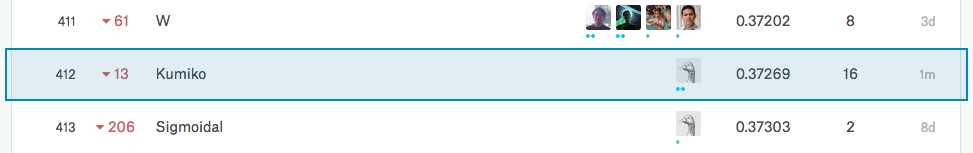

In [11]:
Image(filename='Screen Shot 2017-03-28 at 3.39.32 PM.png')